In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Imports and Paths

In [2]:
from pathlib import Path
import gc

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.linalg
import copy
import sklearn
import rastermap
import pandas as pd
from tqdm.notebook import tqdm

import tensorly as tl
import tensorly.decomposition
import torch

In [3]:
# dir_github        = Path(r'D:\RH_local\github').resolve()

# dir_analysisFiles = Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_1511L').resolve()
dir_analysisFiles = Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_g8test/').resolve()

## Directory with F.npy, stat.npy etc.
# dir_s2p         = Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_1511L/statFiles/20230111').resolve()
dir_s2p         = Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_g8test/mouse_g8t/jobNum_0/suite2p/plane0').resolve()
# dir_s2p         = Path(r'C:\Users\Rich Hakim\Downloads\F.npy').resolve()

## Path of iscell. Can be from neural net output (iscell_NN)
path_iscell = dir_analysisFiles / 'iscell_NN_tqm.npy'

## Path of tqm (trace quality metrics). Used to get dFoF parameters
path_tqm = dir_analysisFiles / 'trace_quality.pkl'


dir_save       =  copy.copy(dir_analysisFiles)
path_save = dir_save / 'weights_day0'
# path_save = dir_save / 'weights_day0_PC2'

In [4]:
# import sys
# sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2
from bnpm import torch_helpers, file_helpers, timeSeries, ca2p_preprocessing, welford_moving_2D, linear_regression, similarity, spectral, featurization, decomposition

%load_ext autoreload
%autoreload 2
import roicat

# %load_ext autoreload
# %autoreload 2
# from Big_Ugly_ROI_Tracker.multiEps.multiEps_modules import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
device = torch_helpers.set_device(use_GPU=True)

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)


In [6]:
def get_highest_evr_var(data, factors,  hits):
    evrs = np.zeros(factors.shape[0])
    for i, factor in enumerate(factors):
        _,_,_,evr_total = similarity.orthogonalize(data, factor)
        evrs[i] = evr_total
    evrs[np.logical_not(hits)] = 0
    highest_evr_ind = np.argsort(evrs)[-1]
    return highest_evr_ind, factors[highest_evr_ind,:], evrs

def orthogonalize_simple(data, factor):
    proj_vec = similarity.proj(data, factor)[0]
    return (np.squeeze(data) - np.squeeze(proj_vec))

In [7]:
DEVICE = torch_helpers.set_device(use_GPU=True);

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)


In [8]:
iscell = np.load(path_iscell)
# spks = np.load(path_spks)

In [9]:
tqm = file_helpers.pickle_load(path_tqm)
dFoF_params = tqm['dFoF_params']

In [10]:
## == IMPORT DATA ==
F, Fneu, iscell_s2p, ops, spks_s2p, stat = ca2p_preprocessing.import_s2p(dir_s2p)
n_frames, n_rois = F.shape[1], F.shape[0]
Fs = ops['fs']

In [11]:
# # Oopsie!
# # Mouse g2FB: delete 43000 - 50000 frames
# F = np.delete(F, range(43000,50000), axis=1)
# Fneu = np.delete(Fneu, range(43000,50000), axis=1)

In [12]:
Fneu.shape

(2398, 81000)

In [13]:
frame_height, frame_width = ops['meanImg'].shape[0], ops['meanImg'].shape[1]

# sf = import_and_convert_to_CellReg_spatialFootprints([dir_s2p / 'stat.npy'], frame_height=frame_height, frame_width=frame_width, dtype=np.float32)[0]

data_rois = roicat.data_importing.Data_suite2p([dir_s2p / 'stat.npy'], FOV_height_width=(frame_height, frame_width))
sf = data_rois.spatialFootprints[0]

Completed: Set FOV_height and FOV_width successfully.
Importing spatial footprints from stat files.


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


Imported 1 sessions of spatial footprints into sparse arrays.
Completed: Set spatialFootprints for 1 sessions successfully.
Completed: Created sessionID_concat.
Completed: Created centroids.
Staring: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.


# Prepare dFoF

In [14]:
idx_time_bad = np.arange(0,0)

idx_time_good = np.arange(n_frames)[~np.isin(np.arange(n_frames), idx_time_bad)]

In [15]:
F_toUse = F[iscell][:, idx_time_good]
Fneu_toUse = Fneu[iscell][:, idx_time_good]

In [16]:
# dFoF with reduced percentile for baseline
channelOffset_correction = 0
percentile_baseline = 20
neuropil_fraction = 0.7
win_rolling_percentile = 15*60*30

dFoF, dF, F_neuSub, F_baseline = ca2p_preprocessing.make_dFoF(
    F=F_toUse,
    Fneu=Fneu_toUse,
    neuropil_fraction=neuropil_fraction,
    percentile_baseline=percentile_baseline,
    rolling_percentile_window=win_rolling_percentile,
    multicore_pref=True,
    verbose=True
)
# # Threshold for nonnegativity
# dFoF_z = dFoF / np.std(dFoF,axis=1,keepdims=True)

100%|███████████████████████████████████████████| 36/36 [00:08<00:00,  4.01it/s]


Calculated dFoF. Total elapsed time: 10.9 seconds


In [17]:
np.sum(dFoF > 30)

0

In [18]:
# dFoF[F_baseline < 5] = np.nan
# dFoF = np.nan_to_num(dFoF)

### Look at rastermap

In [156]:
import rastermap

In [157]:
rmap = rastermap.Rastermap(
    n_components=1,
    n_X=40,
    nPC=200,
    init='pca',
    alpha=1.0,
    K=1.0,
    mode='basic',
    verbose=True,
    annealing=True,
    constraints=2,
)

In [158]:
# X = scipy.stats.zscore(dFoF, axis=0).T
# X = scipy.stats.zscore(dFoF, axis=1)
# X = dFoF / np.std(dFoF, axis=1, keepdims=True)
X = dFoF.copy()
rmap.fit(X)

nmin 200
0.11410403251647949
4.706190824508667
4.988086700439453
4.99045205116272
(38, 40)
(70,)
1.0
time; iteration;  explained PC variance
0.27s     0        0.1497      2
0.33s    10        0.3783      4
0.40s    20        0.3950      8
0.46s    30        0.4211      18
0.52s    40        0.4414      28
0.58s    50        0.4622      38
0.63s    60        0.4662      38
0.67s   final      0.4667
0.67s upsampled    0.4667


<IPython.core.display.Javascript object>


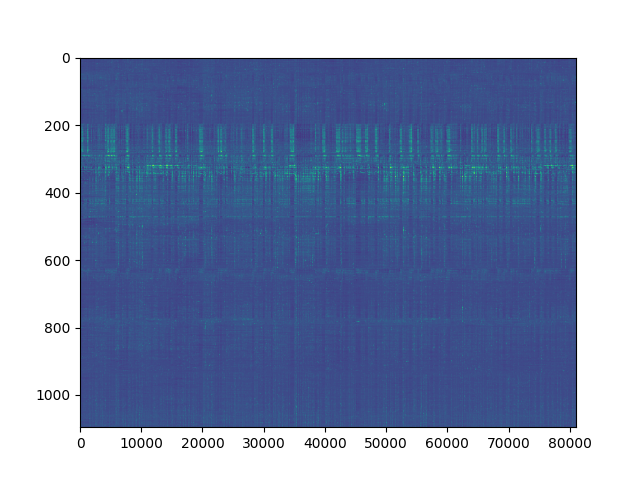

In [159]:
%matplotlib notebook

plt.figure()
plt.imshow(X[rmap.isort], aspect='auto', vmin=-0.5, vmax=2)

# Pre-orthogonalization

### Define traces to orthogonalize out:
- Mean neuron trace (average vector)
    - multiple frequency components
- Mean neuropil trace
    - multiple frequency components

In [19]:
dFoF_mean = np.nanmean(dFoF, axis=0)
Fneu_mean = np.nanmean(Fneu_toUse, axis=0)

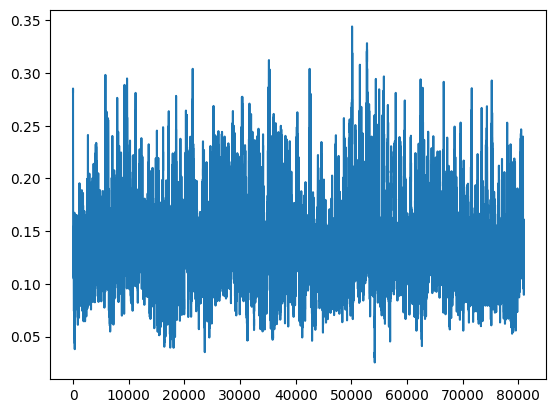

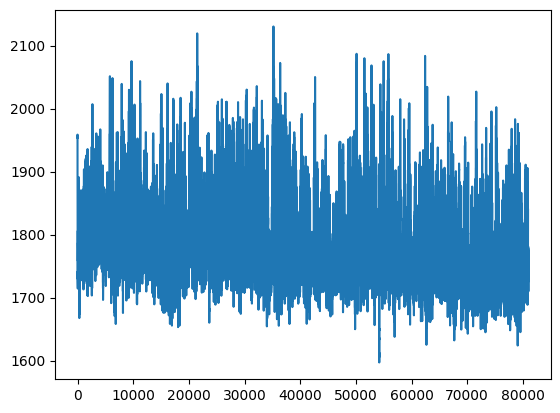

In [20]:
plt.figure()
plt.plot(dFoF_mean)

plt.figure()
plt.plot(Fneu_mean)

### spectral expansion

Make a set of band pass filter, then filter traces with each filter

In [21]:
bandpass_freqs_boundaries = [0, 1/(60*5), 1/20, 1/2, 5, np.inf]

bandpass_ab = [spectral.design_fir_bandpass(bp_1, bp_2, num_taps=10001, fs=Fs, window=('kaiser', 3.0), plot_pref=False) for ii, (bp_1, bp_2) in enumerate(zip(bandpass_freqs_boundaries[:-1], bandpass_freqs_boundaries[1:]))]


In [22]:
traces = [spectral.plot_digital_filter_response(b=h, fs=Fs, worN=100000, plot_pref=False) for h in tqdm(bandpass_ab)]

  0%|          | 0/5 [00:00<?, ?it/s]

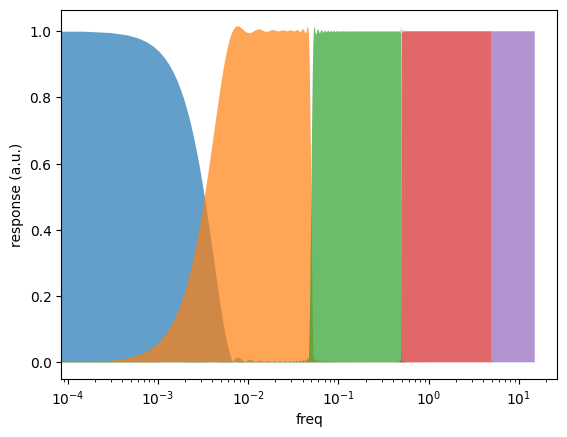

In [23]:
plt.figure()
[(plt.fill_between(t[0], t[1], alpha=0.7), plt.xscale('log'), plt.xlabel('freq'), plt.ylabel('response (a.u.)')) for t in traces];

In [24]:
sigs = np.stack(
    [scipy.signal.filtfilt(h, 1.0, dFoF_mean - dFoF_mean.mean()) for h in tqdm(bandpass_ab)] + \
    [scipy.signal.filtfilt(h, 1.0, Fneu_mean - Fneu_mean.mean()) for h in tqdm(bandpass_ab[:])] + \
    [np.linspace(-1, 1, n_frames, endpoint=True)] + \
    [np.ones(n_frames)] + \
    list(featurization.mspline_grid(3, 5, n_frames)),
    
    axis=0
)

sigs = sigs - sigs.mean(1, keepdims=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


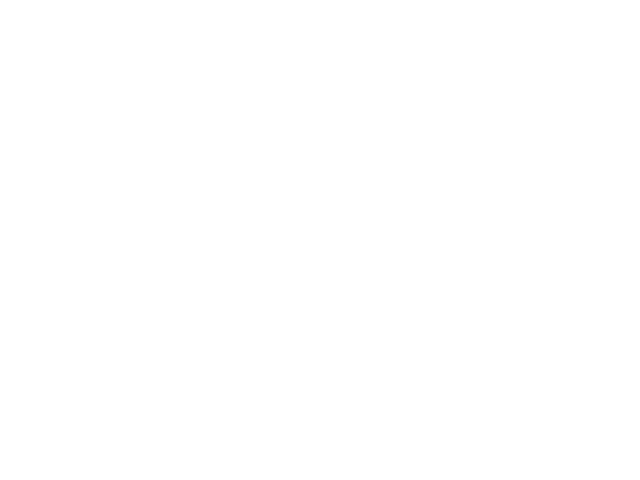

<IPython.core.display.Javascript object>


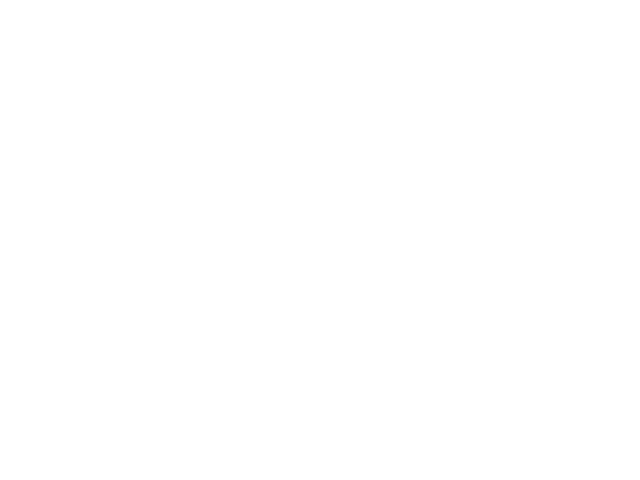

In [25]:
%matplotlib notebook

plt.figure()
plt.plot(sigs.T);

plt.figure()
plt.plot(sigs[:5].sum(0))
plt.plot(dFoF_mean - dFoF_mean.mean())

<IPython.core.display.Javascript object>


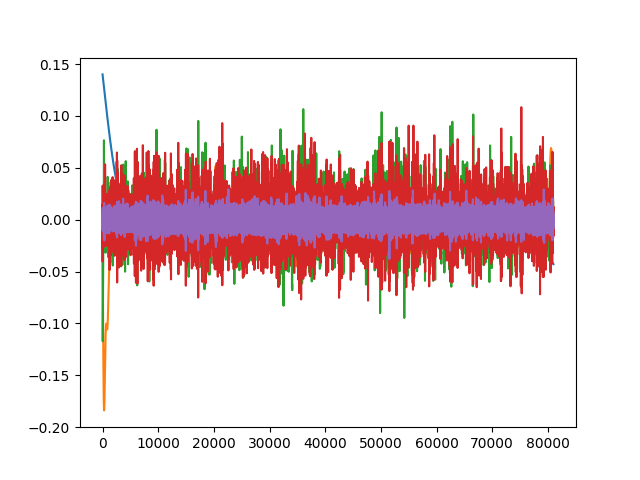

<IPython.core.display.Javascript object>


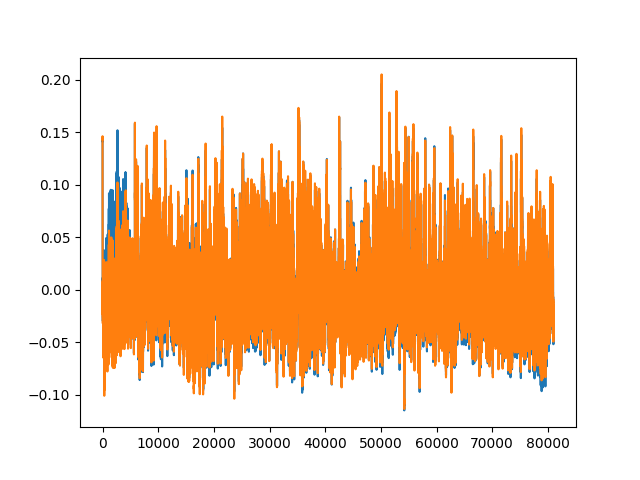

In [26]:
%matplotlib notebook

plt.figure()
plt.plot(sigs[:5].T);

plt.figure()
plt.plot(sigs[:5].sum(0))
plt.plot(dFoF_mean - dFoF_mean.mean())

In [27]:
outs = decomposition.torch_pca(sigs.T, zscore=True, return_numpy=True)

In [28]:
outs[1][:,:-3].T.shape

(14, 81000)

In [29]:
dFoF_roiMeans = dFoF.mean(1, keepdims=True)

theta, y_rec, bias = linear_regression.OLS(X=outs[1][:,:-3], y=(dFoF - dFoF_roiMeans).T, add_bias_terms=False)
# theta, y_rec, bias = linear_regression.OLS(X=sigs.T, y=(dFoF - dFoF_roiMeans).T, add_bias_terms=False)

In [30]:
dFoF_orth = ((dFoF - dFoF_roiMeans).T - y_rec).T

In [31]:
dFoF_orth = dFoF_orth - np.percentile(dFoF_orth, percentile_baseline, axis=1)[:,None]

In [32]:
def orthogonalize_matrix(arr):
    means = arr.mean(1)
    arr_orth = arr - means[:,None]
    for ii in range(1, arr.shape[0]):
        arr_orth[ii] = similarity.orthogonalize(arr_orth[ii], arr_orth[:ii].T)[0].squeeze()

    return arr_orth + means[:,None]

In [33]:
def find_EVR_neuralData_factors(neural_data, factors, device='cpu'):
    """
    neural_data (torch.Tensor):
        shape: (neurons, time)
    factors (torch.Tensor):
        shape: (factor, time)
    """
    out = [similarity.pairwise_orthogonalization_torch(
        torch.as_tensor(neural_data).T.type(torch.float32).to(device), 
        torch.as_tensor(factors[ii]).type(torch.float32).to(device), 
        center=True,
        device=device) for ii in range(len(factors))]

    EVR_total_weighted = np.array([o[2].cpu().numpy() for o in out])
    EVR = np.stack([np.nan_to_num(o[1].cpu().numpy(), 0) for o in out], axis=0).T
    
    return EVR, EVR_total_weighted

In [34]:
def order_factors_by_EVR(factors, data, device='cpu'):
    EVR, EVR_total_weighted = find_EVR_neuralData_factors(data, factors, device=device)
    idx_ordered = np.argsort(EVR_total_weighted)[::-1]
    factors_ordered = factors[idx_ordered]
    
    return factors_ordered, idx_ordered

# Run NMF

In [35]:
tl.set_backend('pytorch')

In [36]:
# Roll a dice and wish for luck
rank = 5

In [37]:
neural_data_toUse = dFoF_orth.copy().astype(np.float32)
neural_data_toUse = np.clip(neural_data_toUse, a_min=0, a_max=None)
# neural_data_toUse = neural_data_toUse - neural_data_toUse.mean(1, keepdims=True)

In [38]:
nmf = tl.decomposition.CP_NN_HALS(
    rank=rank, 
    n_iter_max=1000, 
    init='svd',
    svd='truncated_svd',
    tol=1e-08,
    sparsity_coefficients=None,
    fixed_modes=None, 
    nn_modes='all', 
#     nn_modes=[1],  
    exact=False, 
    verbose=True, 
    normalize_factors=True, 
    cvg_criterion='abs_rec_error'
)
factors_nmf = nmf.fit_transform(torch.as_tensor(neural_data_toUse, dtype=torch.float32, device=device))

# factors_nmf = tl.decomposition.non_negative_parafac_hals(
#     tensor=torch.as_tensor(neural_data_toUse, dtype=torch.float32, device=device),
#     rank=rank, 
#     n_iter_max=1000, 
#     init='svd',
#     svd='truncated_svd',
#     tol=1e-07,
#     sparsity_coefficients=None,
#     fixed_modes=None, 
# #     nn_modes='all', 
#     nn_modes=(False, True), 
#     exact=False,
#     verbose=True,
#     normalize_factors=True,    
#     cvg_criterion='abs_rec_error'
# )

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/tensorly/backend/pytorch_backend.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(


reconstruction error=0.6944366693496704
iteration 1, reconstruction error: 0.6872329115867615, decrease = 0.0072037577629089355
iteration 2, reconstruction error: 0.6831521391868591, decrease = 0.004080772399902344
iteration 3, reconstruction error: 0.6808946132659912, decrease = 0.00225752592086792
iteration 4, reconstruction error: 0.6794930696487427, decrease = 0.0014015436172485352
iteration 5, reconstruction error: 0.678596019744873, decrease = 0.0008970499038696289
iteration 6, reconstruction error: 0.678022563457489, decrease = 0.0005734562873840332
iteration 7, reconstruction error: 0.6776514053344727, decrease = 0.0003711581230163574
iteration 8, reconstruction error: 0.6774052381515503, decrease = 0.0002461671829223633
iteration 9, reconstruction error: 0.6772368550300598, decrease = 0.00016838312149047852
iteration 10, reconstruction error: 0.6771199703216553, decrease = 0.00011688470840454102
iteration 11, reconstruction error: 0.6770382523536682, decrease = 8.1717967987060

iteration 94, reconstruction error: 0.676630437374115, decrease = 4.827976226806641e-06
iteration 95, reconstruction error: 0.6766257286071777, decrease = 4.708766937255859e-06
iteration 96, reconstruction error: 0.67662113904953, decrease = 4.589557647705078e-06
iteration 97, reconstruction error: 0.6766165494918823, decrease = 4.589557647705078e-06
iteration 98, reconstruction error: 0.6766120195388794, decrease = 4.5299530029296875e-06
iteration 99, reconstruction error: 0.6766077280044556, decrease = 4.291534423828125e-06
iteration 100, reconstruction error: 0.6766034364700317, decrease = 4.291534423828125e-06
iteration 101, reconstruction error: 0.6765993237495422, decrease = 4.112720489501953e-06
iteration 102, reconstruction error: 0.6765953302383423, decrease = 3.993511199951172e-06
iteration 103, reconstruction error: 0.6765915751457214, decrease = 3.7550926208496094e-06
iteration 104, reconstruction error: 0.6765877604484558, decrease = 3.814697265625e-06
iteration 105, recon

iteration 189, reconstruction error: 0.676434338092804, decrease = 1.2516975402832031e-06
iteration 190, reconstruction error: 0.6764330267906189, decrease = 1.3113021850585938e-06
iteration 191, reconstruction error: 0.6764318346977234, decrease = 1.1920928955078125e-06
iteration 192, reconstruction error: 0.6764305233955383, decrease = 1.3113021850585938e-06
iteration 193, reconstruction error: 0.676429271697998, decrease = 1.2516975402832031e-06
iteration 194, reconstruction error: 0.676427960395813, decrease = 1.3113021850585938e-06
iteration 195, reconstruction error: 0.6764266490936279, decrease = 1.3113021850585938e-06
iteration 196, reconstruction error: 0.6764252185821533, decrease = 1.430511474609375e-06
iteration 197, reconstruction error: 0.6764236688613892, decrease = 1.5497207641601562e-06
iteration 198, reconstruction error: 0.6764222383499146, decrease = 1.430511474609375e-06
iteration 199, reconstruction error: 0.6764208674430847, decrease = 1.3709068298339844e-06
iter

In [39]:
factors_temporal_nmf = factors_nmf.factors[1].cpu().numpy().T
factors_neuron_nmf = factors_nmf.factors[0].cpu().numpy().T

In [40]:
scores_nmf = (neural_data_toUse.T @ factors_neuron_nmf.T).T

In [41]:
factors_neuron_nmf_orth = orthogonalize_matrix(factors_neuron_nmf)

In [42]:
scores_nmf_orth = (neural_data_toUse.T @ factors_neuron_nmf_orth.T).T

In [43]:
factors_neuron_nmf_orth_ms = factors_neuron_nmf_orth - factors_neuron_nmf_orth.mean(1, keepdims=True)
scores_nmf_orth_ms = (neural_data_toUse.T @ factors_neuron_nmf_orth_ms.T).T

In [44]:
_, order = order_factors_by_EVR(scores_nmf_orth_ms, neural_data_toUse, device=device)

In [45]:
factors_neuron_nmf_orth_ms_ordered = factors_neuron_nmf_orth_ms[order]
scores_nmf_orth_ms_ordered = (neural_data_toUse.T @ factors_neuron_nmf_orth_ms_ordered.T).T

In [46]:
scores_nmf_orth_ms_ordered_raw = (dFoF.T @ factors_neuron_nmf_orth_ms_ordered.T).T

In [47]:
factors_neuron_nmf_orth_ms_ordered_norm = factors_neuron_nmf_orth_ms_ordered / factors_neuron_nmf_orth_ms_ordered.std(1, keepdims=True)

In [48]:
scores_nmf_orth_ms_ordered_raw_norm = dFoF.T @ factors_neuron_nmf_orth_ms_ordered_norm.T

In [49]:
torch_helpers.clear_cuda_cache()

<IPython.core.display.Javascript object>


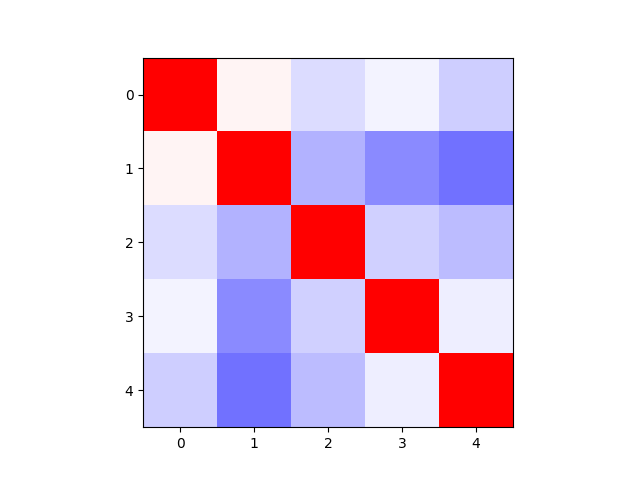

In [109]:
plt.figure()
plt.imshow(np.corrcoef(factors_temporal_nmf), cmap='bwr', clim=[-1,1])

<IPython.core.display.Javascript object>


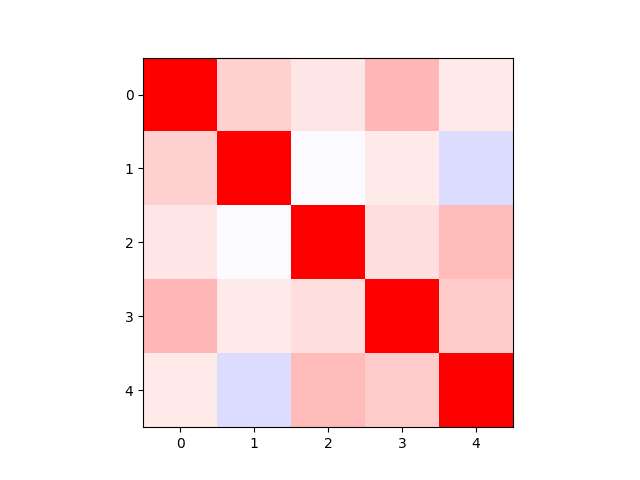

In [110]:
plt.figure()
plt.imshow(np.corrcoef(factors_neuron_nmf), cmap='bwr', clim=[-1,1])

<IPython.core.display.Javascript object>


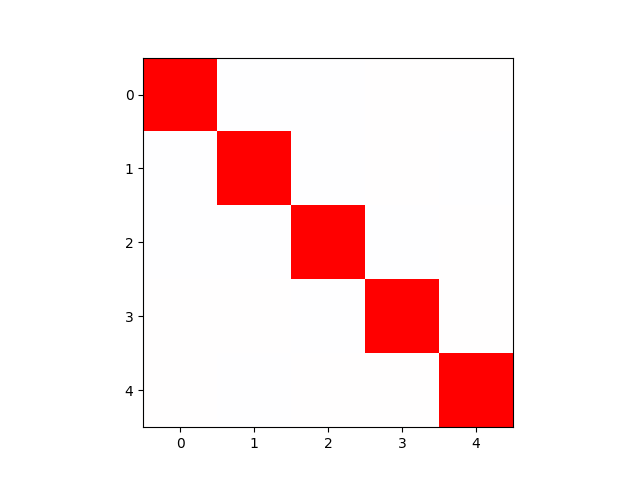

In [111]:
plt.figure()
plt.imshow(np.corrcoef(factors_neuron_nmf_orth), cmap='bwr', clim=[-1,1])

<IPython.core.display.Javascript object>


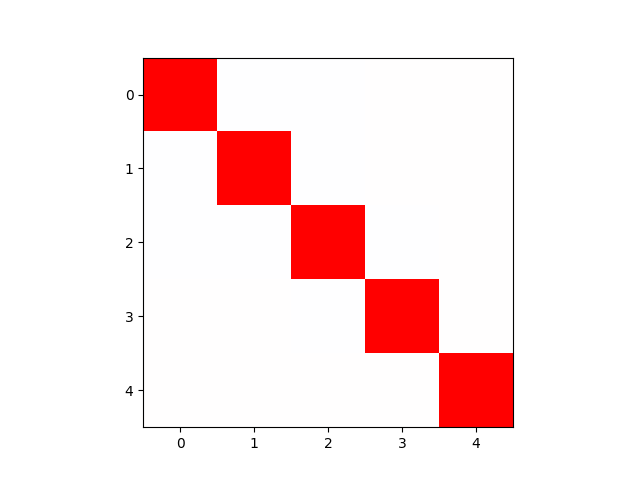

In [112]:
plt.figure()
plt.imshow(np.corrcoef(factors_neuron_nmf_orth_ms), cmap='bwr', clim=[-1,1])

<IPython.core.display.Javascript object>


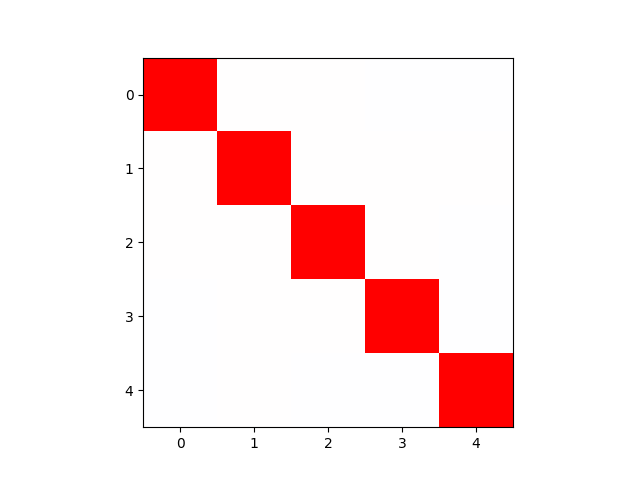

In [113]:
plt.figure()
plt.imshow(np.corrcoef(factors_neuron_nmf_orth_ms_ordered), cmap='bwr', clim=[-1,1])

<IPython.core.display.Javascript object>


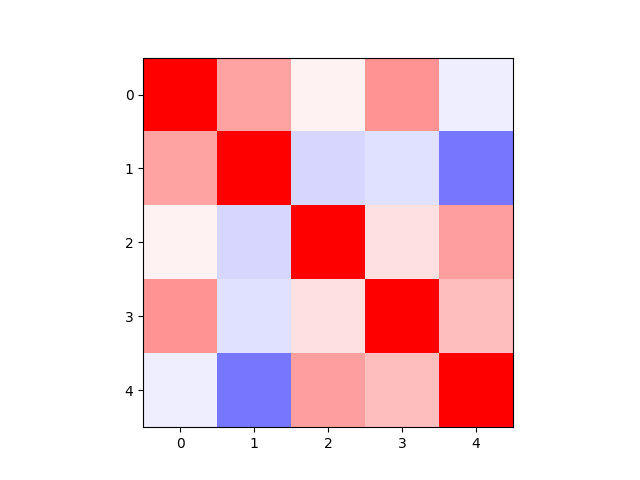

In [114]:
plt.figure()
plt.imshow(np.corrcoef(scores_nmf), cmap='bwr', clim=[-1,1])

<IPython.core.display.Javascript object>


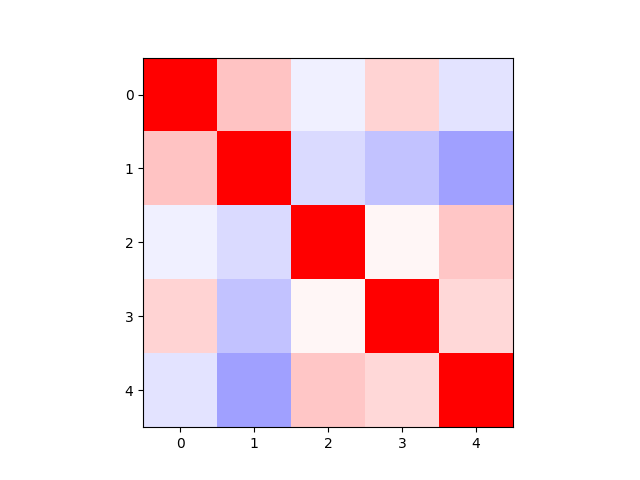

In [115]:
plt.figure()
plt.imshow(np.corrcoef(scores_nmf_orth), cmap='bwr', clim=[-1,1])

<IPython.core.display.Javascript object>


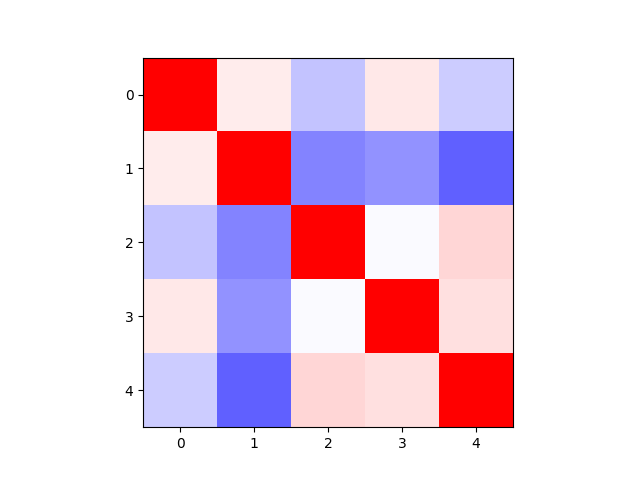

In [116]:
plt.figure()
plt.imshow(np.corrcoef(scores_nmf_orth_ms), cmap='bwr', clim=[-1,1])

<IPython.core.display.Javascript object>


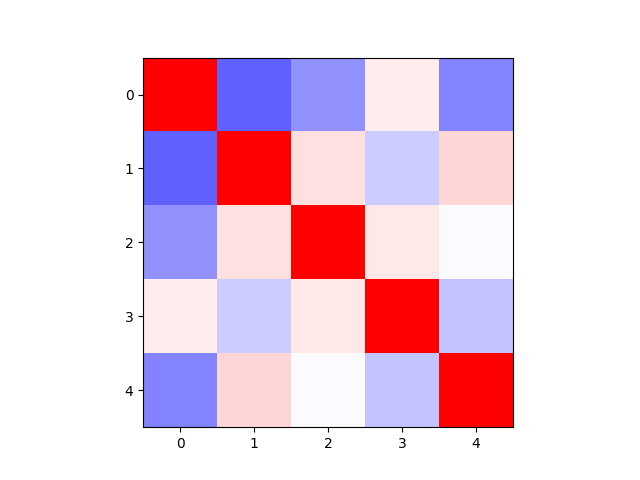

In [117]:
plt.figure()
plt.imshow(np.corrcoef(scores_nmf_orth_ms_ordered), cmap='bwr', clim=[-1,1])

<IPython.core.display.Javascript object>


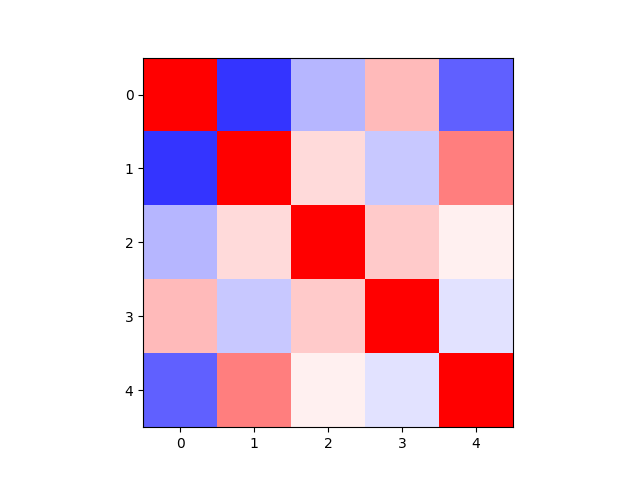

In [118]:
plt.figure()
plt.imshow(np.corrcoef(scores_nmf_orth_ms_ordered_raw), cmap='bwr', clim=[-1,1])

<IPython.core.display.Javascript object>


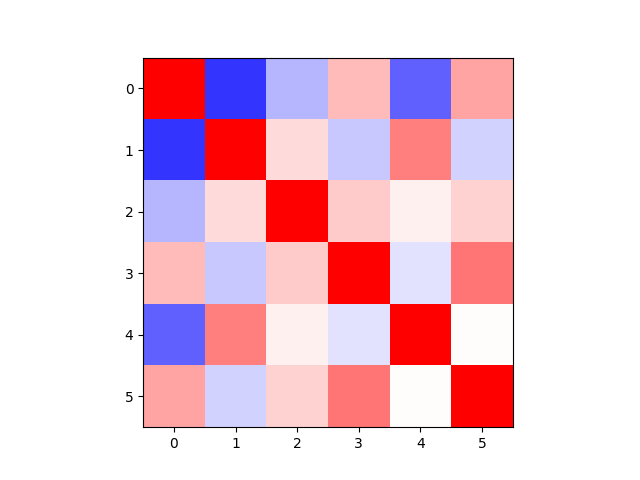

In [119]:
plt.figure()
plt.imshow(np.corrcoef(np.concatenate((
    scores_nmf_orth_ms_ordered_raw,
    dFoF_mean[None,:]
), axis=0)), cmap='bwr', clim=[-1,1])

<IPython.core.display.Javascript object>


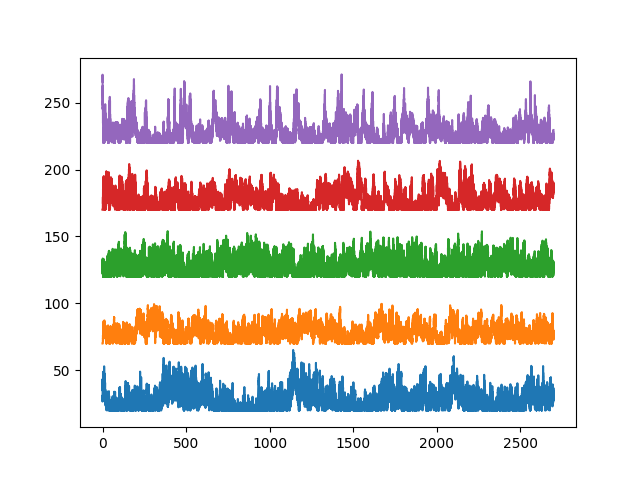

<IPython.core.display.Javascript object>


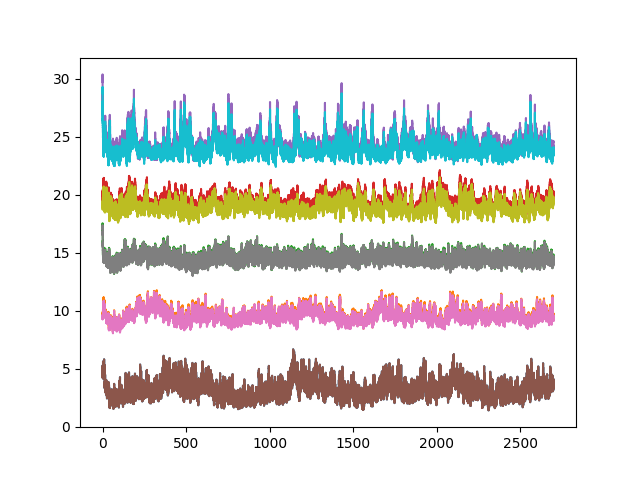

<IPython.core.display.Javascript object>


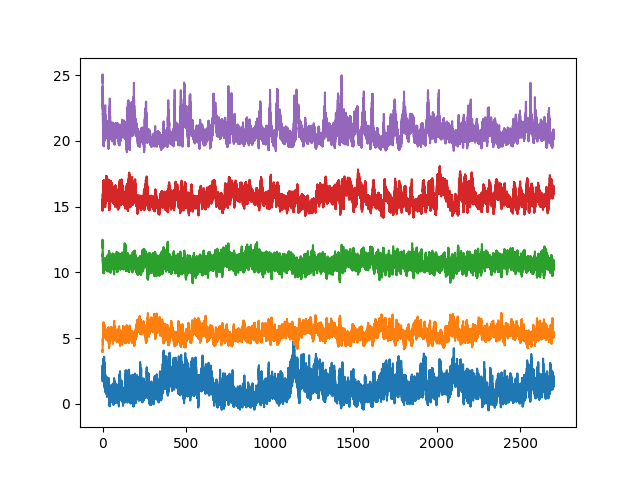

<IPython.core.display.Javascript object>


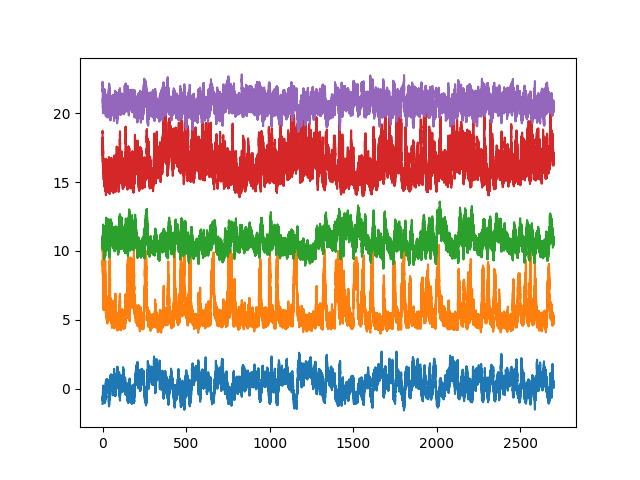

In [120]:
plt.figure()
plt.plot(np.arange(factors_temporal_nmf.shape[1])/Fs,  factors_temporal_nmf.T*3000 + 20 + 50*np.arange(rank)[None,:]);

plt.figure()
plt.plot(np.arange(factors_temporal_nmf.shape[1])/Fs,  scores_nmf.T + 5*np.arange(rank)[None,:]);
plt.plot(np.arange(factors_temporal_nmf.shape[1])/Fs,  scores_nmf_orth.T + 5*np.arange(rank)[None,:]);

plt.figure()
plt.plot(np.arange(factors_temporal_nmf.shape[1])/Fs,  scores_nmf_orth_ms.T + 5*np.arange(rank)[None,:]);

plt.figure()
plt.plot(np.arange(factors_temporal_nmf.shape[1])/Fs,  scores_nmf_orth_ms_ordered_raw.T + 5*np.arange(rank)[None,:]);

<IPython.core.display.Javascript object>


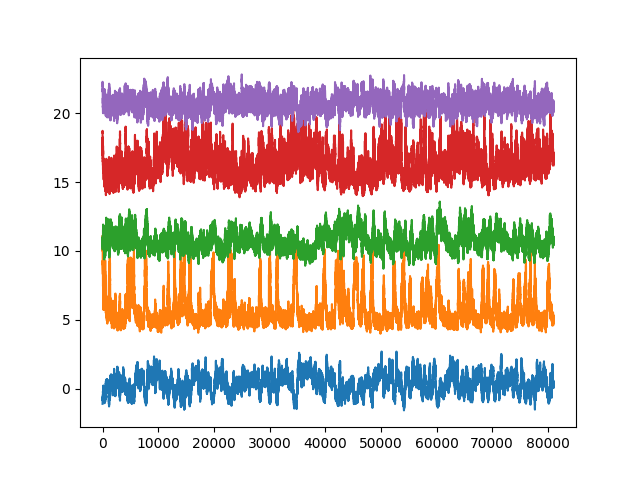

In [121]:
plt.figure()
plt.plot(scores_nmf_orth_ms_ordered_raw.T + 5*np.arange(rank)[None,:]);

In [122]:
class Decoder_angle_magnitude:
    def __init__(self, F, power=2.0, dtype=torch.float32, device='cpu'):
        """
        Angle-magnitude decoder.

        Args:
            F (np.ndarray or torch.Tensor):
                Factor matrix.
                Either shape: (n_neurons, n_components) or shape: (n_neurons,)
            p (np.ndarray or torch.Tensor or float or int):
                Power coefficient. Tunes the angular specificity of the decoder.
                Scalar value.
            dtype (torch.dtype):
                Data type to use for computations.
            device (str):
                Device to use for computations. Either 'cpu' or 'cuda'.
        """
        # Set attributes
        self.power = power
        self._dtype = dtype
        self._device = device

        if isinstance(F, np.ndarray):
            self.F = torch.as_tensor(F).type(self._dtype).to(self._device)
        else:
            self.F = F.type(self._dtype).to(self._device)
        assert isinstance(self.F, torch.Tensor), "F must be a torch.Tensor or np.ndarray."

        self.n_components = int(self.F.shape[1])
        self.d_bools = torch.cat([torch.arange(0, self.n_components)[None,:] == ii for ii in range(self.n_components)], dim=0).type(self._dtype).to(self._device)  # shape: (n_components, n_components)

    def __call__(self, X, F=None, power=None):
        """
        Angle-magnitude decoder.

        Args:
            X (np.ndarray or torch.Tensor): 
                Neural data (dFoF: either timeseries or timepoint).
                Either shape: (n_neurons, n_timepoints) or shape: (n_neurons,)
            F (np.ndarray or torch.Tensor):
                Factor matrix.
                If None, uses self.F.
                Either shape: (n_neurons, n_components) or shape: (n_neurons,)
            p (np.ndarray or torch.Tensor or float or int):
                Power coefficient. Tunes the angular specificity of the decoder.
                If None, uses self.power.
                Scalar value.

        Returns:
            D (torch.Tensor):
                Values for each decoder dimension.
                Shape: (n_components, n_timepoints)
            CS (torch.Tensor):
                Cosine similarity between each decoder dimension and each timepoint.
                Shape: (n_components, n_timepoints)
            M (torch.Tensor):
                Magnitude of each decoder dimension.
                Shape: (n_components, n_timepoints)
        """
        # Convert to torch.Tensor
        if isinstance(X, np.ndarray):
            X = torch.as_tensor(X).type(self._dtype).to(self._device)
        if F is not None:
            if isinstance(F, np.ndarray):
                F = torch.as_tensor(F).type(self._dtype).to(self._device)
        else:
            F = self.F.type(self._dtype).to(self._device)
        assert F is not None, "F must be provided as an argument or as an attribute."
        
        p = float(power) if power is not None else self.power

        # Check shapes
        if len(X.shape) == 1:
            X = X[:,None]
        if len(F.shape) == 1:
            F = F[:,None]

        # Compute factor magnitudes
        M = ((X.T @ F) / torch.linalg.norm(F, dim=0)).T  # shape: (n_components, n_timepoints)

        # Compute cursor as (cosine_similarity(D, i) * projection_magnitude(D_i))**p
        # d_bools = torch.cat([torch.arange(0, M.shape[1])[None,:] == ii for ii in range(M.shape[1])], dim=0).type(self._dtype).to(self._device)  # shape: (n_components, n_components)
        CS = torch.cat([torch.nn.functional.cosine_similarity(M, db_ii[:,None], dim=0, eps=1e-8)[None,:] for db_ii in self.d_bools], dim=0)  # shape: (n_components, n_timepoints)
        D = torch.abs(CS)**p * M  # shape: (n_components, n_timepoints)

        return D, CS, M

In [613]:
def make_evr_power_curve(factors, data, powers=[0, 1, 2, 3, 5, 10], device='cpu'):
    decoder = Decoder_angle_magnitude(
        F=factors.T,
        device=device
    )
    
    Ds = [decoder(X=data, power=p)[0] for p in powers]
    
    evrs = [similarity.orthogonalize(data.T, d.T, device=device)[-1] for d in Ds]
    
    return evrs

In [485]:
components, scores, singVals, EVR = decomposition.torch_pca(neural_data_toUse.T, mean_sub=True, device=device, return_numpy=True)

In [618]:
vals_power = np.concatenate([[0], np.linspace(0.1**0.5,10, 30)**2])

evrs = [make_evr_power_curve(f, neural_data_toUse, powers=vals_power, device=device) for f in [factors_neuron_nmf_orth_ms_ordered_norm, components.T[:rank]]]

<IPython.core.display.Javascript object>


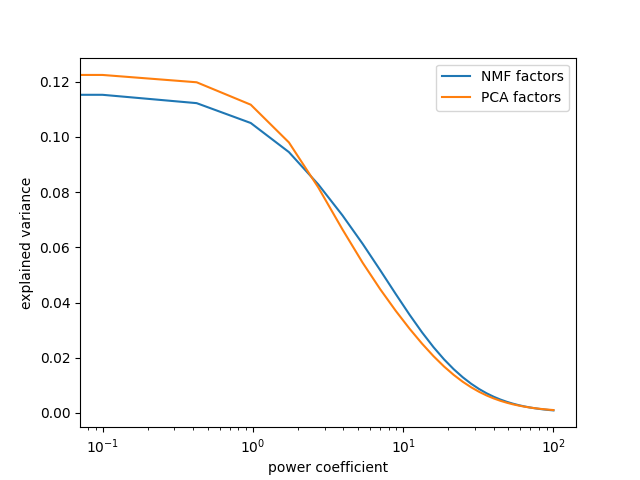

In [619]:
plt.figure()
plt.plot(vals_power, evrs[0])
plt.plot(vals_power, evrs[1])
plt.ylabel('explained variance')
plt.xlabel('power coefficient')
plt.xscale('log')
plt.legend(['NMF factors', 'PCA factors'])

In [170]:
torch.as_tensor(neural_data_toUse).T.shape

torch.Size([81000, 1096])

In [171]:
y_rec.T.shape

torch.Size([1096, 81000])

In [198]:
theta, y_rec, bias = linear_regression.OLS(Ds[0].T, torch.as_tensor(neural_data_toUse).T, add_bias_terms=True)

In [199]:
similarity.pairwise_orthogonalization_torch(torch.as_tensor(neural_data_toUse).T, y_rec)

(tensor([[ 1.1048,  1.9406, -0.1900,  ..., -0.0416, -0.0756, -0.0851],
         [ 0.9774,  2.6262, -0.3839,  ...,  0.0271, -0.0738, -0.0823],
         [ 1.1108,  2.3058, -0.3855,  ..., -0.0555, -0.0396,  0.0799],
         ...,
         [ 0.1007,  0.9368,  0.1011,  ..., -0.1131,  0.0264, -0.1491],
         [ 0.2462,  0.4522, -0.0197,  ..., -0.1130, -0.1077,  0.0546],
         [-0.0191,  0.6732,  0.1540,  ...,  0.0052, -0.0254, -0.1338]]),
 tensor([0.2863, 0.3782, 0.5241,  ..., 0.0022, 0.0061, 0.0779]),
 tensor(0.0803),
 tensor(0.0378))

In [181]:
1 - (torch.linalg.norm(torch.as_tensor(y_rec - y_rec.mean(0))) / torch.linalg.norm(torch.as_tensor(neural_data_toUse - neural_data_toUse.mean(1, keepdims=True)).T))

tensor(0.7163)

In [183]:
1 - (torch.linalg.norm(torch.as_tensor(neural_data_toUse) - y_rec.T) / torch.linalg.norm(torch.as_tensor(neural_data_toUse)))

tensor(0.3153)

<IPython.core.display.Javascript object>


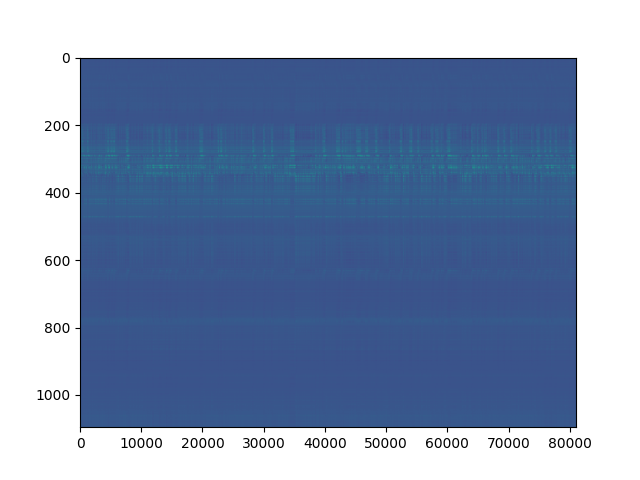

In [160]:
plt.figure()
plt.imshow(y_rec.T[rmap.isort], aspect='auto')

<IPython.core.display.Javascript object>


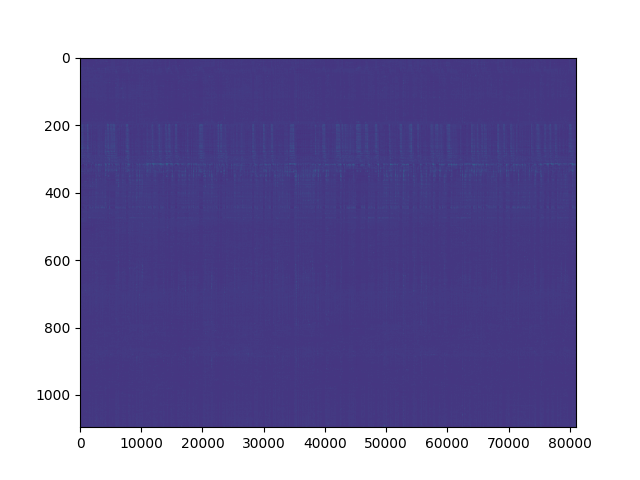

In [145]:
plt.figure()
plt.imshow(dFoF[rmap.isort], aspect='auto')

In [133]:
y_rec.shape

torch.Size([81000, 1096])

<IPython.core.display.Javascript object>


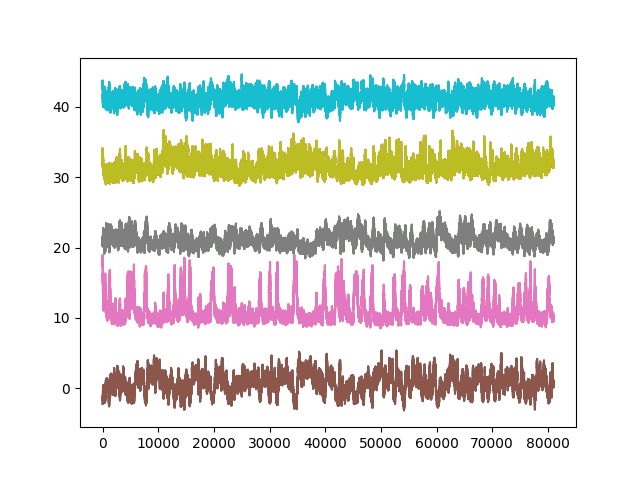

In [105]:
plt.figure()
plt.plot(M + torch.arange(rank)[None,:]*10)
plt.plot(Ds[0] + torch.arange(rank)[None,:]*10)

<IPython.core.display.Javascript object>


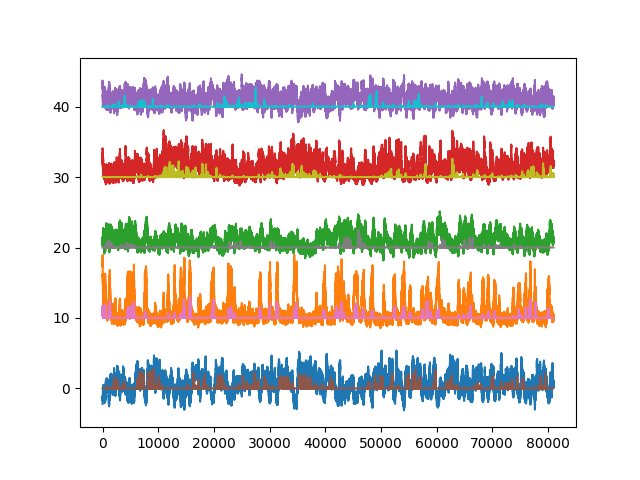

In [106]:
plt.figure()
plt.plot(M + torch.arange(rank)[None,:]*10)
plt.plot(Ds[-1] + torch.arange(rank)[None,:]*10)

In [356]:
D.shape

torch.Size([81000, 5])

<IPython.core.display.Javascript object>


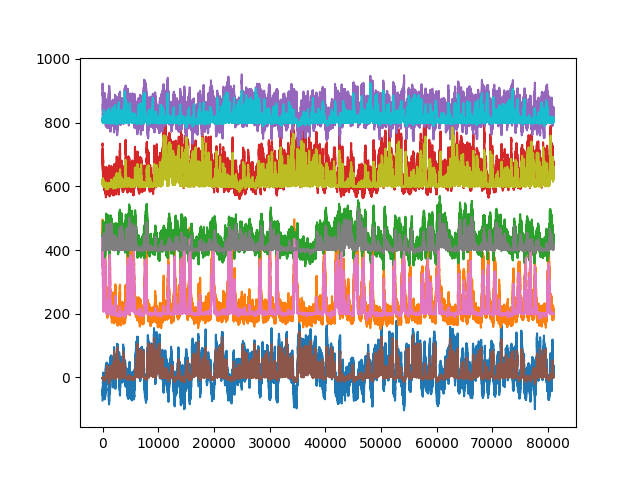

In [271]:
plt.figure()
plt.plot(s_norm + np.arange(s_norm.shape[1])[None,:]*200);
plt.plot(simulated_scores_nmf_orth_ms_ordered_raw_norm + np.arange(rank)[None,:]*200);

<IPython.core.display.Javascript object>


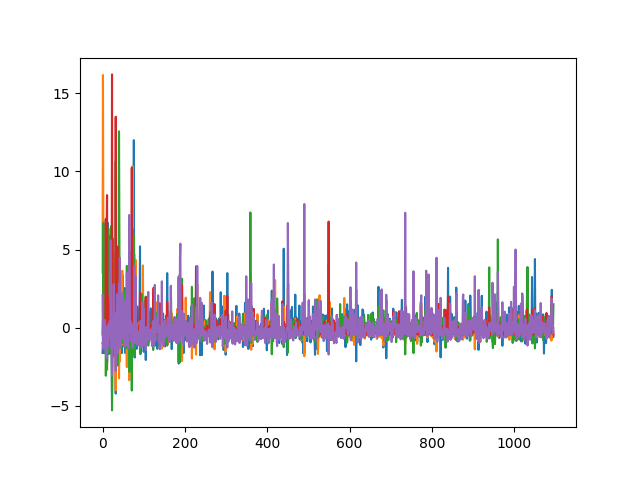

In [272]:
plt.figure()
plt.plot(factors_neuron_nmf_orth_ms_ordered_norm.T)

<IPython.core.display.Javascript object>


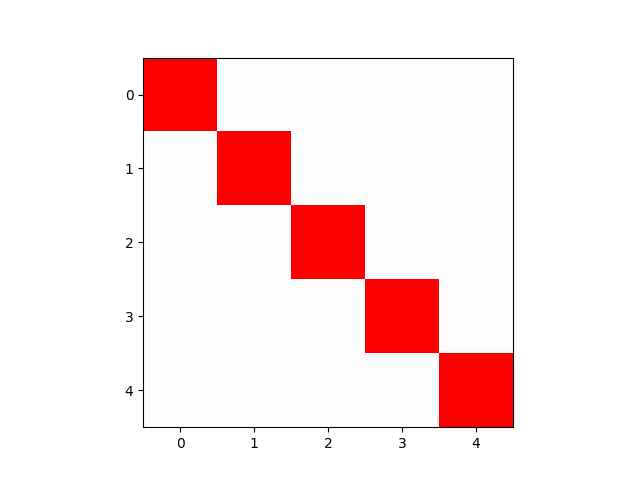

In [273]:
plt.figure()
plt.imshow(np.corrcoef(
    np.concatenate(
        (
            factors_neuron_nmf_orth_ms_ordered_norm,
        ),
        axis=0
    )),
           cmap='bwr', vmin=-1, vmax=1
)

<IPython.core.display.Javascript object>


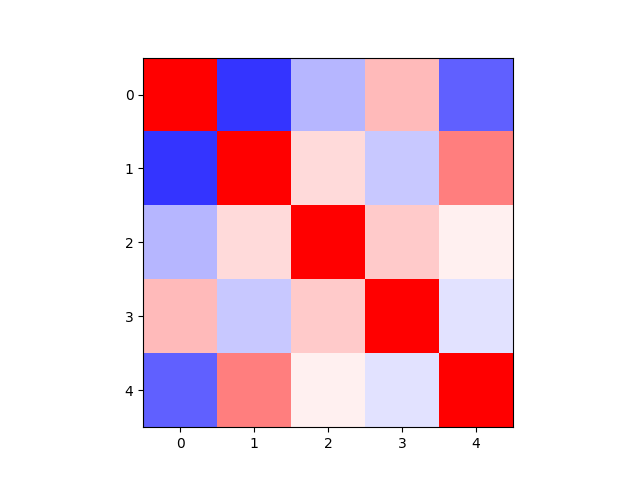

In [274]:
plt.figure()
plt.imshow(np.corrcoef(
    np.concatenate(
        (
            scores_nmf_orth_ms_ordered_raw_norm.T,
        ),
        axis=0
    )),
           cmap='bwr', vmin=-1, vmax=1
)

<IPython.core.display.Javascript object>


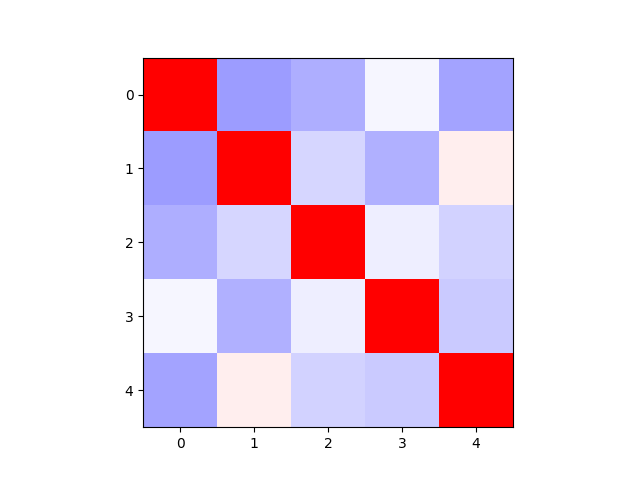

In [275]:
plt.figure()
plt.imshow(np.corrcoef(
    np.concatenate(
        (
            simulated_scores_nmf_orth_ms_ordered_raw_norm.T,
        ),
        axis=0
    )),
           cmap='bwr', vmin=-1, vmax=1
)

In [294]:
cc = np.concatenate([similarity.pairwise_similarity(dFoF.T, s) for s in simulated_scores_nmf_orth_ms_ordered_raw_norm.T], axis=1)

In [295]:
cc.shape

(1096, 5)

<IPython.core.display.Javascript object>


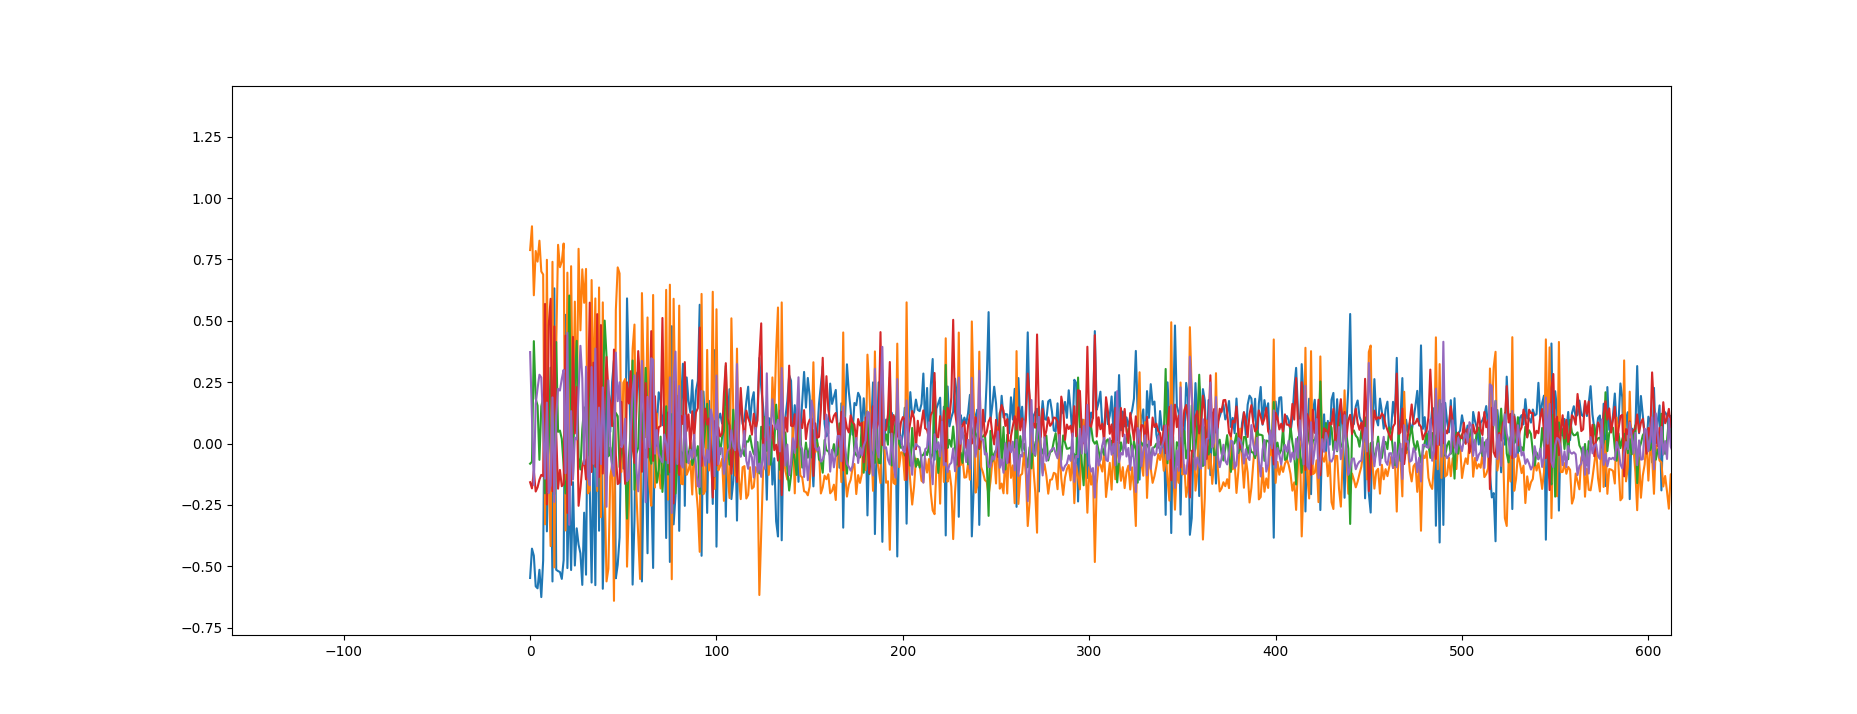

In [296]:
plt.figure()
plt.plot(cc)

<IPython.core.display.Javascript object>


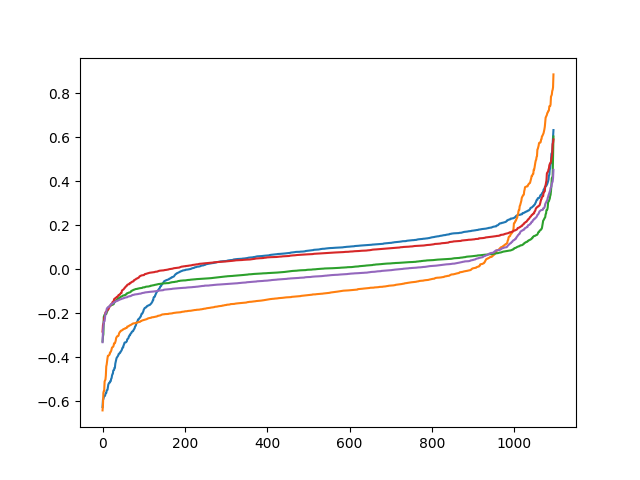

In [309]:
plt.figure()
plt.plot(np.sort(cc, axis=0))

<IPython.core.display.Javascript object>


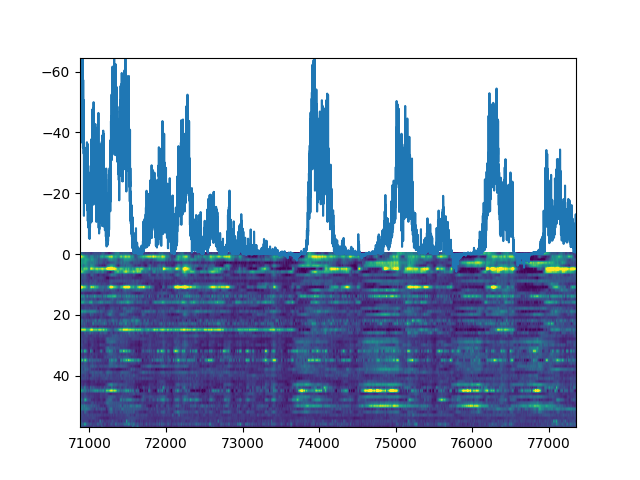

In [310]:
idx = 2

plt.figure()
plt.imshow(dFoF[np.argsort(cc[:,idx])][::-1], aspect='auto', vmin=-0.2, vmax=1.5)
plt.plot(simulated_scores_nmf_orth_ms_ordered_raw_norm[:,idx]*-1)

<IPython.core.display.Javascript object>


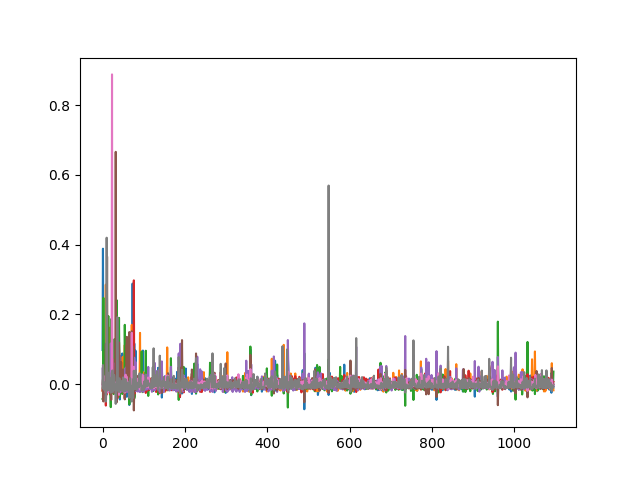

In [221]:
plt.figure()
plt.plot(factors_neuron_nmf_orth_ms_ordered.T);

<IPython.core.display.Javascript object>


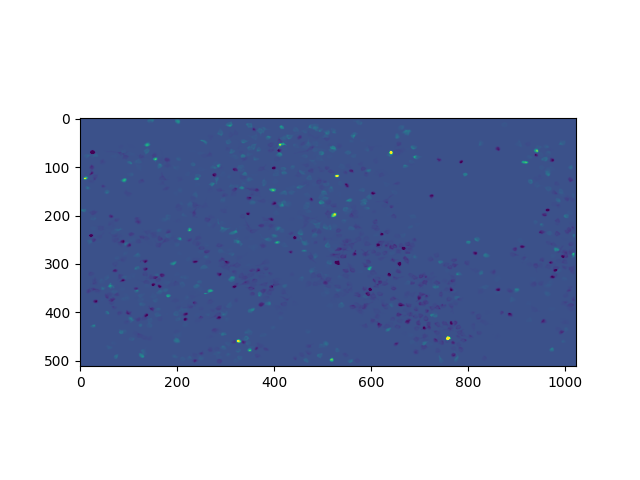

interactive(children=(IntSlider(value=0, description='i_frame', max=4), Output()), _dom_classes=('widget-inter…

In [315]:
weights = factors_neuron_nmf_orth_ms_ordered_norm.copy()
sf_weights = (sf[iscell].T * weights.T).T.reshape(rank, data_rois.FOV_height, data_rois.FOV_width)

%matplotlib notebook
roicat.visualization.display_toggle_image_stack(
    sf_weights, 
    clim=[sf_weights.min()/4, sf_weights.max()/4]
)

In [316]:
import sklearn

<IPython.core.display.Javascript object>


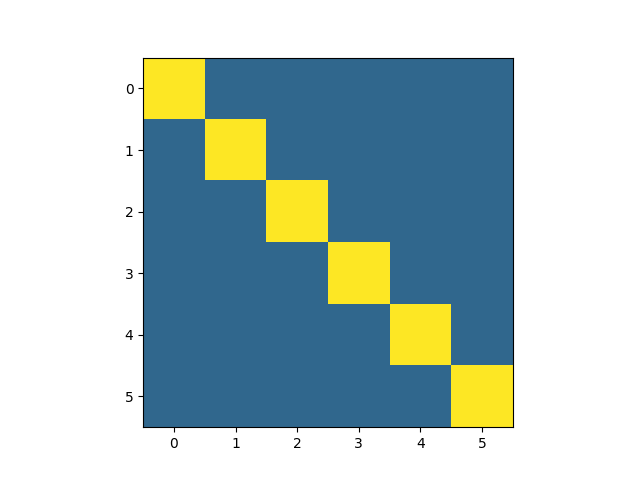

In [317]:
plt.figure()
plt.imshow(sklearn.metrics.pairwise.cosine_similarity(np.concatenate((
    weights, 
    np.ones(weights.shape[1])[None,:],
), axis=0)), vmin=-0.5, vmax=1)


visualization of final traces and masks

# Save it all

In [95]:
weights_day0 = {
#     "weights": weights[:,factor_to_use],
    "weights_all" : weights,
    "iscell_custom": iscell,
#     "factor_to_use": factor_to_use,
    "sf_weights": sf_weights,
#     "factors_temporal": factors_temporal_tokeep,
    "factors_temporal": scores_nmf_orth_ms_ordered,
}


F = scipy.io.savemat(path_save.with_suffix('.mat') , weights_day0)

np.save(path_save.with_suffix('.npy') , weights_day0)

# Load in old outputs

In [1]:
import numpy as np

In [2]:
data = np.load(r'D:/RH_local/data/BMI_cage_1511_4/mouse_1511L/20230111/analysis_data/weights_day0.npy', allow_pickle=True)[()]

In [3]:
data.keys()

dict_keys(['weights', 'weights_all', 'iscell_custom', 'factor_to_use', 'sf_weights', 'factors_temporal'])

In [6]:
import bnpm.plotting_helpers

<IPython.core.display.Javascript object>


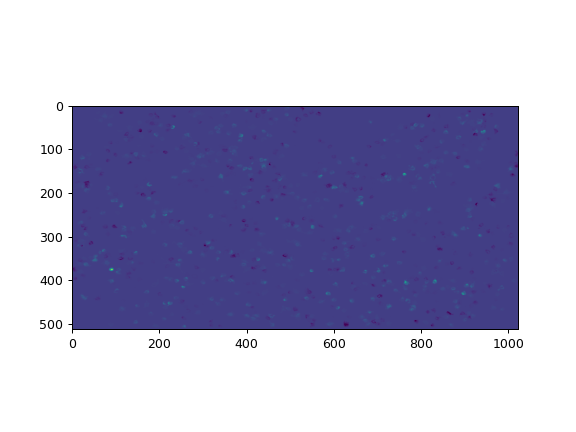

interactive(children=(IntSlider(value=0, description='i_frame', max=5), Output()), _dom_classes=('widget-inter…

In [17]:
# weights = theta[:,np.argsort(evrs)[::-1]]
# sf_weights = np.einsum('ij,ikl->jkl', data['weights_all'], sf[data['iscell_custom']])

%matplotlib notebook
bnpm.plotting_helpers.display_toggle_image_stack(data['sf_weights'])

In [ ]:
components , scores , explained_variance_ratio_ , stds = decomposition.simple_pca(neural_data_toUse.T.cpu().numpy() , n_components=None , mean_sub=True, zscore=False, plot_pref=True , n_PCs_toPlot=2)

In [ ]:
factors_orth_regression.shape

In [8]:
Fs = 30

In [10]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


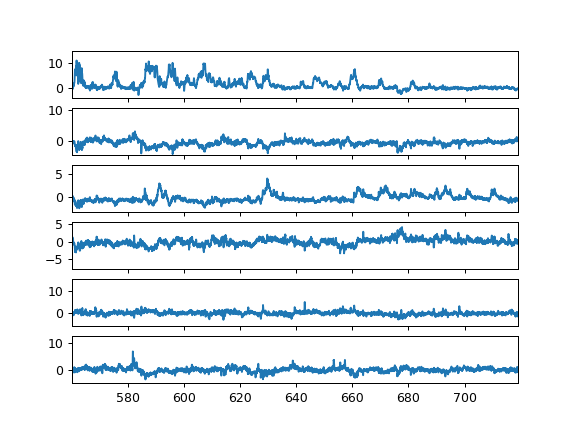

In [18]:
%matplotlib notebook
fig, axs = plt.subplots(data['factors_temporal'].shape[0], 1, sharex=True)
for ii in range(axs.shape[0]):
#     axs[ii,0].plot(np.arange(data['factors_temporal'].shape[1])/Fs, factors_orth_regression[np.argsort(evrs)[-ii-1],:].T)
    axs[ii].plot(np.arange(data['factors_temporal'].shape[1])/Fs, data['factors_temporal'][ii])

<IPython.core.display.Javascript object>


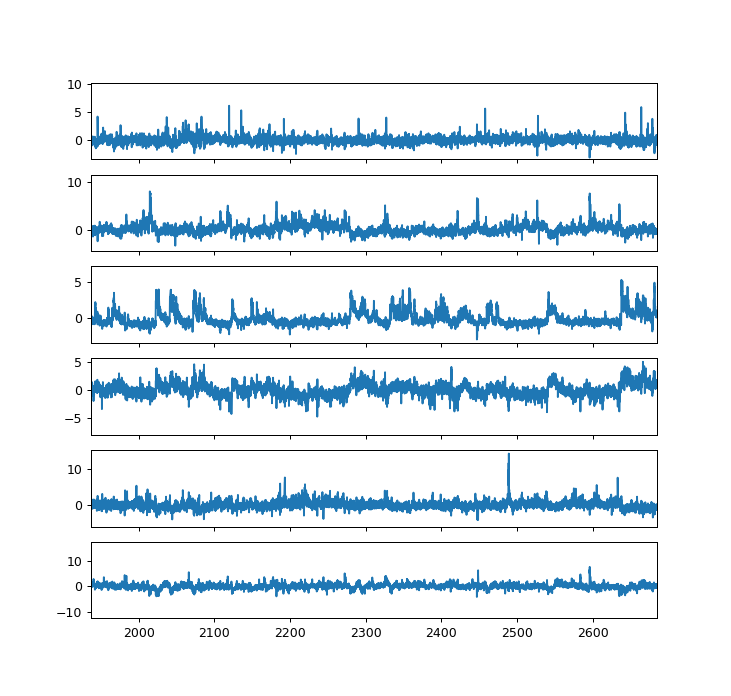

In [14]:
%matplotlib notebook
fig, axs = plt.subplots(data['factors_temporal'].shape[0], 1, sharex=True)
for ii in range(axs.shape[0]):
#     axs[ii,0].plot(np.arange(data['factors_temporal'].shape[1])/Fs, factors_orth_regression[np.argsort(evrs)[-ii-1],:].T)
    axs[ii].plot(np.arange(data['factors_temporal'].shape[1])/Fs, data['factors_temporal'][ii])

<IPython.core.display.Javascript object>


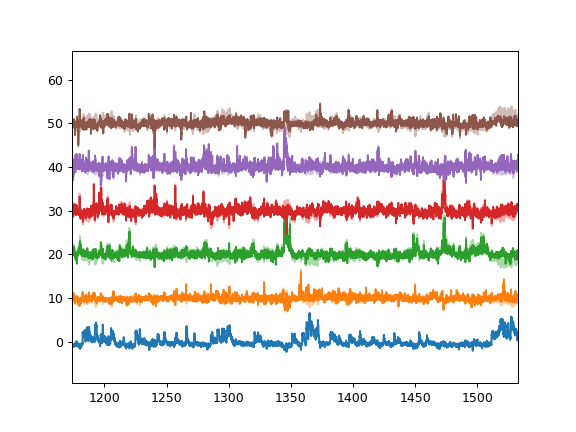

In [372]:
%matplotlib notebook
plt.figure()
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_temporal_tokeep[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good),alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_orth_regression[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good))

In [ ]:
import rastermap

In [ ]:
rmap = rastermap.Rastermap(
    n_components=1,
    n_X=40,
#     nPC=200,
#     init='pca',
#     alpha=1.0,
#     K=1.0,
#     mode='basic',
#     verbose=True,
#     annealing=True,
#     constraints=2,
)

In [ ]:
# embedding = rmap.fit_transform(neural_data_toUse.cpu().numpy())
# embedding = rmap.fit_transform(dFoF)
embedding = rmap.fit_transform(np.concatenate([neural_data_toUse.cpu().numpy()[:,indices_to_use], factors_orth_regression]))

In [ ]:
plt.figure()
plt.hist(embedding, 400);
plt.hist(embedding[-10:], 100);

In [ ]:
plt.figure()
plt.imshow(
#     timeSeries.scale_between(neural_data_toUse.cpu().numpy()[rmap.isort], lower_percentile=10, upper_percentile=90), 
#     timeSeries.scale_between(spks_s2p[rmap.isort], lower_percentile=10, upper_percentile=90), 
#     dFoF[rmap.isort], vmax=5, 
    np.concatenate([neural_data_toUse.cpu().numpy()[:,indices_to_use], factors_orth_regression])[rmap.isort], 
    vmin=0,
    vmax=5, 
    aspect='auto',
#     extent=[0, indices_to_use.max()/Fs, 0, neural_data_toUse.shape[0]]
)
plt.xticks(ticks=np.arange(0,factors_temporal_tokeep.shape[1], 10000), labels=np.round(np.arange(0,factors_temporal_tokeep.shape[1], 10000)/Fs))

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1,sharex=True)
ax1.imshow(
#     timeSeries.scale_between(neural_data_toUse.cpu().numpy()[rmap.isort], lower_percentile=10, upper_percentile=90), 
#     timeSeries.scale_between(spks_s2p[rmap.isort], lower_percentile=10, upper_percentile=90), 
#     dFoF[rmap.isort], vmax=5, 
    np.concatenate([neural_data_toUse.cpu().numpy()[:,indices_to_use], factors_orth_regression])[rmap.isort], 
    vmin=0,
    vmax=5, 
    aspect='auto',
#     extent=[0, indices_to_use.max()/Fs, 0, neural_data_toUse.shape[0]]
)
#ax1.set_xticks(ticks=np.arange(0,factors_temporal_tokeep.shape[1], 10000), labels=np.round(np.arange(0,factors_temporal_tokeep.shape[1], 10000)/Fs))
ax2.plot(factors_temporal_tokeep[np.argsort(evrs)[::-1],:].T + 10*np.arange(10),alpha=0.4)
ax2.plot(factors_orth_regression[np.argsort(evrs)[::-1],:].T + 10*np.arange(10))

In [ ]:
indices_to_use.shape